In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pprint import pprint
from scipy.stats import invgamma
from scipy.integrate import trapezoid
from scipy.integrate import quad
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from time import sleep
import scipy.stats as st
from scipy.special import gamma

In [2]:
def read_in(paths, manhatten_ids):
    dfs = []
    for i,path in enumerate(paths):
        clear_output(wait=True)
        print(str(i+1) + "/" + str(len(paths)))
        data = pd.read_csv(path)[["passenger_count", "trip_distance", "PULocationID", "DOLocationID"]]
        data = data[data["passenger_count"] > 0]
        data = data[data["trip_distance"] > 0]
        data = data[data["trip_distance"] < 8]
        data = data[data["PULocationID"].isin(manhatten_ids) & data["DOLocationID"].isin(manhatten_ids)]
        dfs.append(data)
        
    return pd.concat(dfs)

In [3]:
lookup_df = pd.read_csv("/project.dcf/poss/datasets/NYTaxiData/taxi+_zone_lookup.csv.gz")
manhatten_df = lookup_df[lookup_df["Borough"] == "Manhattan"]
manhatten_ids = manhatten_df["LocationID"].values

data_path = "/project.dcf/poss/datasets/NYTaxiData/2018/"
files = []
to_load_dirs = ["Yellow"]
for root,subdirs,subfiles in os.walk(data_path):
#     if "Green" in root or "Yellow" in root:
    if any([e in root for e in to_load_dirs]):
        for file in subfiles:
            files.append(os.path.join(root, file))

data = read_in(files, manhatten_ids)

12/12


In [4]:
print(len(data))
display(data.head())

84844385


,passenger_count,trip_distance,PULocationID,DOLocationID
7,1,1.19,229,161
9,1,3.10,234,50
10,1,1.68,244,42
11,1,4.00,239,244
12,1,0.60,68,246


In [5]:
#Cleaning
trip_dists = data["trip_distance"]
trip_dists = np.round(trip_dists, 2)
trip_dists = trip_dists[~np.isin(trip_dists, np.round(np.linspace(0,8,81), 1))]

trip_dists *= 1.609344
trip_dists = trip_dists[trip_dists >= 0.5]
trip_dists = trip_dists[trip_dists <= 12]

# plt.figure()

# plt.scatter(vals, counts, s=1)

# plt.show()

In [6]:
# Create hist and renormalize distances / counts, create sample for faster fitting

vals, counts = np.unique(trip_dists, return_counts=True)
renorm = trip_dists.mean()
vals = vals/renorm
trip_dists /= renorm

norm = trapezoid(counts, vals)
counts = counts/norm

sample = trip_dists.sample(10000)

In [7]:
# Define custom inv gamma distribution and fit to data sample

class taxi_dist_gen(st.rv_continuous):
    def _pdf(self, x, k):
        a = k-1
        b = k-2
        return b**a/gamma(a)*x**(-k)*np.exp(-b/x)
#         return invgamma.pdf(x, k-1, 0, k-2)

# taxi_dist = taxi_dist_gen(name='taxi_dist')

params = invgamma.fit(sample, floc=0)#, fscale=1.)
# params = taxi_dist.fit(sample)#, floc=0)#, fscale=1.)

print(params)
print("k = ", params[0]+1)

(2.6128933682293853, 0, 1.7273584470388785)
k =  3.6128933682293853


/scratch.local/hheuer/NYTaxiDataAnalysis/env/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


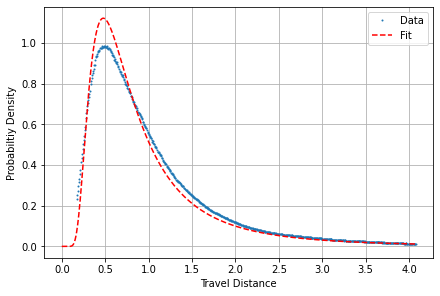

In [14]:
%matplotlib inline
fig, ax = plt.subplots(constrained_layout=True)

# trip_dists.hist(bins=75, density=True, histtype="step", grid=False, lw=2, ax=ax, color="blue")
ax.plot(vals, counts, "o", ms=1, label="Data")

x = np.linspace(0,vals[-1],1000)
ax.plot(x, invgamma.pdf(x, *params), ls="--", color="red", label="Fit")

ax.set_xlabel("Travel Distance")
ax.set_ylabel("Probabiltiy Density")
ax.grid()

ax.legend()
ax.set_title('')

# fig.savefig("InverseGammaFit.pgf")
plt.show()

In [15]:
# Other distributions for testing
class my_invgamma_gen(st.rv_continuous):
    def _pdf(self, x, a):
        return x**(-a-1)/gamma(a)*np.exp(-1/x)

class gaussian_gen(st.rv_continuous):
    "Gaussian distribution"
    def _pdf(self, x):
        return np.exp(-x**2 / 2.) / np.sqrt(2.0 * np.pi)
    
gaussian = gaussian_gen(name='gaussian')
my_invgamma = my_invgamma_gen(name='my_invgamma')

In [16]:
print(my_invgamma.fit(sample))
# print(gaussian.fit(sample))

/scratch.local/hheuer/NYTaxiDataAnalysis/env/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._pdf, _a, x, args=args)[0]


(3.6752163756882803, -0.13374637497992864, 3.0881451696594775)


/scratch.local/hheuer/NYTaxiDataAnalysis/env/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1826: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]
/scratch.local/hheuer/NYTaxiDataAnalysis/env/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2605: RuntimeWarning: invalid value encountered in sqrt
  Shat = sqrt(mu2hat / mu2)


k =  3.8470311104476176


/tmp/ipykernel_2053161/4064127414.py:8: RuntimeWarning: divide by zero encountered in power
  return b**a/gamma(a)*(x-c)**(-k)*np.exp(-b/(x-c))
/tmp/ipykernel_2053161/4064127414.py:8: RuntimeWarning: divide by zero encountered in true_divide
  return b**a/gamma(a)*(x-c)**(-k)*np.exp(-b/(x-c))
/tmp/ipykernel_2053161/4064127414.py:8: RuntimeWarning: invalid value encountered in multiply
  return b**a/gamma(a)*(x-c)**(-k)*np.exp(-b/(x-c))


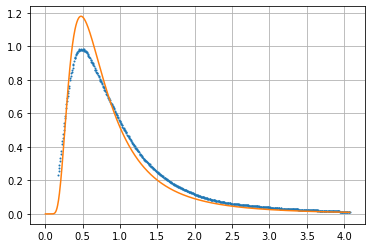

In [18]:
# Fit with least squares

Δ = lambda z, k, α = 1, β=0: α * np.exp( -1 / (z-β) ) / (z-β)**k

def mft_corrected(x, k, c=0):
    a = k-1
    b = k-2
    return b**a/gamma(a)*(x-c)**(-k)*np.exp(-b/(x-c))


func = mft_corrected
popt, pcov = curve_fit(func, vals, counts, p0=[3])

print("k = ", *popt)

plt.figure()
x = np.linspace(0, vals[-1], 1000)
plt.plot(vals, counts, "o", ms=1)
plt.plot(x, func(x, *popt))

plt.grid()

plt.show()

In [12]:
print(quad(mft_corrected,0,np.infty,args=tuple(popt)))

(0.9999999999947251, 1.463715716412215e-08)
